# Follow up post to modeling NFL game outcomes using Python and scikit-learn (and introducing pycaret)

# Intro
This is a follow up to the post I wrote [here](https://www.opensourcefootball.com/posts/2021-01-21-nfl-game-prediction-using-logistic-regression/), with some help from [Tim Bryan](https://www.twitter.com/timbryan000), on modeling NFL game outcomes using scikit-learn. In this post, we set out to improve our model, and introduce a couple more prediction metrics (such as examining the AUC curve, precision-recall curve, and confusion matrix) that we didn't have time to touch on. This time, since we're able to reuse a lot of the code, we can spend more time digging in and examining the model.

We also introduce another Python library to help us select our model, PyCaret (recall that last-time we used Logistic Regression but didn't put too much thought in to which was likely to be the best model). PyCaret is an open-source, low-code machine learning library in Python that allows you to train and deploy machine learning models quickly and easily. It was designed to be user-friendly and to reduce the time and effort required to implement machine learning algorithms. PyCaret provides a suite of functions for preprocessing, training, and evaluating machine learning models, as well as tools for model selection and hyperparameter tuning. It also includes features for automatic data visualization and reporting, making it a useful tool for both beginners and experienced machine learning practitioners. Hopefully it can smooth the learning curve for some of the R users who may not be as familiar with Python.

# Recap and model improvements

To recap from last time - we created a Logistic Regression model to predict NFL game outcomes. Our features were based on exponentially-weighted moving average of a team's own and their opponents EPA metrics. Additionally, we used a dynamic window, building upon Jack Lichtenstein's work, which showed that using a dynamic vs. a static window size was slightly optimal. This dynamic window size worked like this: if we were looking at a game before week 10, we applied a window size = 10 and used some prior season data. For example, if we were looking at a team's point-in-time metrics on week 4, then we'd use weeks 1-3 plus the latest 7 games from the previous season. If we were past week 10, we'd just use an entire season's data. 

The main improvement's Tim and I have made to this project here:

1. Used a different model. This time we use a GradientBoost Classifier instead of Logistic Regression. We explain the reasoning behind this decision later on in this post.
2. Added another layer to our features by including an adjustment for league average EPA, building upon Jonathan Goldberg's work [here](https://www.opensourcefootball.com/posts/2020-08-20-adjusting-epa-for-strenght-of-opponent/).

Some things have also changed from last time. Instead of using the `nflfastpy` library, we are using `nfl-data-py` library for loading our data source, which comes from nflfastR. `nflfastpy` which was started by myself has been deprecated, also by myself (I was overambitious in taking on the responsibility to actually maintain that package, truth be told). Thankfully some great folks started up `nfl-data-py` which does what `nflfastpy` did but even better. Great!

# Loading Data

To start off, let's import some dependencies. If you're primarily an R user and want to follow along, I'd suggest using Google Colab for an easy and painless setup (you may need to pip install pycaret and nfl_data_py).

In [3]:
# import dependencies
import nfl_data_py as nfl

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

Next, we can import our data with `nfl_data_py`. I'm using the IPython magic command here `%%capture` to surpress the cell's output so we don't see `nfl-data-py` telling us that a year has been loaded.

In [4]:
%%capture
# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2000, 2023))

Now let's use the head method just to make sure our data looks correct.

In [5]:
data.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

## Preprocessing

After loading the data, the next step is preprocessing (engineering our features). As discussed, we already made decent headway in the previous post for this part. 

Let's briefly recap what features we chose for our model last time, how we engineered them, and then after discuss what improvements we are making this time:

First off, our target for this model will be a home team win. All of our features used to predict this target will be derived from EPA. We'll need EPA features that tell us about the home team and away team in each case.

EPA will be split in to defense and offense for both teams, and then further split in to passing and rushing. This means in total, we’ll have 8 features:

1. Home team passing offense EPA/play
2. Home team passing defense EPA/play
3. Home team rushing offense EPA/play
4. Home team rushing defense EPA/play
5. Away team passing offense EPA/play
6. Away team passing defense EPA/play
7. Away team rushing offense EPA/play
8. Away team rushing defense EPA/play

Each of these features will be lagged one period, and then an exponential moving average will be calculated using the dynamic window size we described above. That gets us to what we did last time. We are going to paste in the code below to just get us back up to speed (if you want to see detailed descriptions of how the code works it's in the last post, skipping over for this one).

In [7]:
# Reusing the dynamic window ewma function from the previous post
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)

# Seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush'] == 1, :]\
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush'] == 1, :]\
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass'] == 1, :]\
    .groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass'] == 1, :]\
    .groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# Lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
    .apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
    .apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
    .apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
    .apply(dynamic_window_ewma).values

In short, we are now left with 4 DataFrames that we can use to extract our features: `rushing_offense_epa`, `rushing_defense_epa`, `passing_offense_epa`, `passing_defense_epa`. You can maybe see where this is going: we are going to be joining these 4 DataFrames together with schedule data to examine each team's EPA figures leading into a matchup. 

Below, we examine all 4 DataFrames:

In [12]:
display(rushing_offense_epa.head())
display(rushing_defense_epa.head())
display(passing_offense_epa.head())
display(passing_defense_epa.head())

,posteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,-0.483617,NaN,NaN,NaN
1,ARI,2000,2,-0.276743,-0.483617,-0.483617,-0.483617
2,ARI,2000,4,-0.334533,-0.276743,-0.369836,-0.369836
3,ARI,2000,5,-0.058684,-0.334533,-0.355644,-0.355644
4,ARI,2000,6,-0.010326,-0.058684,-0.257809,-0.257809


,defteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,0.146122,NaN,NaN,NaN
1,ARI,2000,2,-0.168889,0.146122,0.146122,0.146122
2,ARI,2000,4,-0.018524,-0.168889,-0.027134,-0.027134
3,ARI,2000,5,-0.022732,-0.018524,-0.023673,-0.023673
4,ARI,2000,6,0.113402,-0.022732,-0.023363,-0.023363


,posteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,0.059045,NaN,NaN,NaN
1,ARI,2000,2,0.660259,0.059045,0.059045,0.059045
2,ARI,2000,4,-0.273369,0.660259,0.389713,0.389713
3,ARI,2000,5,0.049141,-0.273369,0.123158,0.123158
4,ARI,2000,6,0.271449,0.049141,0.098773,0.098773


,defteam,season,week,epa,epa_shifted,ewma,ewma_dynamic_window
0,ARI,2000,1,-0.009200,NaN,NaN,NaN
1,ARI,2000,2,0.312221,-0.009200,-0.009200,-0.009200
2,ARI,2000,4,0.427810,0.312221,0.167582,0.167582
3,ARI,2000,5,0.058499,0.427810,0.272192,0.272192
4,ARI,2000,6,-0.120929,0.058499,0.201790,0.201790


Now, for the improvement to our model from last time: we are going to be looking at these 8 features again for use in our model *in excess of league averages*.

In [7]:
# Create new DataFrames based on team specific epa DataFrames to hold league averages for each EPA category
# Drop the team column and group by season and week
rushing_offense_epa_league = rushing_offense_epa.drop(columns=['posteam'], inplace=False)\
    .groupby(['season', 'week'], as_index=False).mean()
rushing_defense_epa_league = rushing_defense_epa.drop(columns=['defteam'], inplace=False)\
    .groupby(['season', 'week'], as_index=False).mean()
passing_offense_epa_league = passing_offense_epa.drop(columns=['posteam'], inplace=False)\
    .groupby(['season', 'week'], as_index=False).mean()
passing_defense_epa_league = passing_defense_epa.drop(columns=['defteam'], inplace=False)\
    .groupby(['season', 'week'], as_index=False).mean()

# Add a dynamic EWMA column for the league average
rushing_offense_epa_league['ewma_dynamic_window_league'] = rushing_offense_epa_league.groupby(['season', 'week'], as_index=False)\
     .apply(dynamic_window_ewma).values

rushing_defense_epa_league['ewma_dynamic_window_league'] = rushing_defense_epa_league.groupby(['season', 'week'], as_index=False)\
    .apply(dynamic_window_ewma).values

passing_offense_epa_league['ewma_dynamic_window_league'] = passing_offense_epa_league.groupby(['season', 'week'], as_index=False)\
    .apply(dynamic_window_ewma).values

passing_defense_epa_league['ewma_dynamic_window_league'] = passing_defense_epa_league.groupby(['season', 'week'], as_index=False)\
    .apply(dynamic_window_ewma).values

# Simplifiy and drop all measure columns except for the ewma dynamic window
rushing_offense_epa = rushing_offense_epa[[
    'posteam', 'season', 'week', 'ewma_dynamic_window']]

rushing_defense_epa = rushing_defense_epa[[
    'defteam', 'season', 'week', 'ewma_dynamic_window']]

passing_offense_epa = passing_offense_epa[[
    'posteam', 'season', 'week', 'ewma_dynamic_window']]

passing_defense_epa = passing_defense_epa[[
    'defteam', 'season', 'week', 'ewma_dynamic_window']]

rushing_offense_epa_league = rushing_offense_epa_league[[
    'season', 'week', 'ewma_dynamic_window_league']]

rushing_defense_epa_league = rushing_defense_epa_league[[
    'season', 'week', 'ewma_dynamic_window_league']]

passing_offense_epa_league = passing_offense_epa_league[[
    'season', 'week', 'ewma_dynamic_window_league']]

passing_defense_epa_league = passing_defense_epa_league[[
    'season', 'week', 'ewma_dynamic_window_league']]

Now that we have the league averages for each of our EPA categories, we can merge it back into original EPA dataframes.

In [10]:
# Join the league averages back to the team specific EPA data
rushing_offense_epa = rushing_offense_epa.merge(rushing_offense_epa_league, on=['season', 'week'], how='left')

rushing_defense_epa = rushing_defense_epa.merge(rushing_defense_epa_league, on=['season', 'week'], how='left')

passing_offense_epa = passing_offense_epa.merge(passing_offense_epa_league, on=['season', 'week'], how='left')

passing_defense_epa = passing_defense_epa.merge(passing_defense_epa_league, on=['season', 'week'], how='left')

In [11]:
# Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
    .rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
    .rename(columns={'defteam': 'team'})
epa = offense_epa.merge(
    defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#Remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa

,team,season,week,ewma_dynamic_window_rushing_offense,ewma_dynamic_window_league_rushing_offense,ewma_dynamic_window_passing_offense,ewma_dynamic_window_league_passing_offense,ewma_dynamic_window_rushing_defense,ewma_dynamic_window_league_rushing_defense,ewma_dynamic_window_passing_defense,ewma_dynamic_window_league_passing_defense
0,ARI,2001,2,-0.257620,-0.205947,-0.175331,0.036229,0.018773,-0.189916,0.111821,0.076577
1,ARI,2001,3,-0.276913,-0.129966,-0.109405,0.042306,0.013838,-0.137436,0.184540,0.004772
2,ARI,2001,4,-0.234329,-0.138268,-0.094911,0.059601,-0.002316,-0.150027,0.259115,0.049905
3,ARI,2001,5,-0.199981,-0.076297,-0.032882,-0.076207,0.001047,-0.097703,0.213552,-0.075239
4,ARI,2001,6,-0.269542,-0.158078,-0.009407,0.080178,0.000615,-0.130386,0.152927,0.117979
...,...,...,...,...,...,...,...,...,...,...,...
11625,WAS,2022,9,-0.108892,-0.059248,-0.075413,0.022507,-0.158079,-0.032386,0.050929,0.077406
11626,WAS,2022,10,-0.075243,-0.068316,-0.105758,0.049673,-0.177981,-0.045260,0.051040,0.031661
11627,WAS,2022,11,-0.052450,-0.093796,-0.076421,0.078619,-0.130164,-0.105120,0.002442,0.040908
11628,WAS,2022,12,-0.067271,-0.134368,-0.055683,0.090820,-0.188580,-0.153093,-0.046631,0.089434


## Visualization

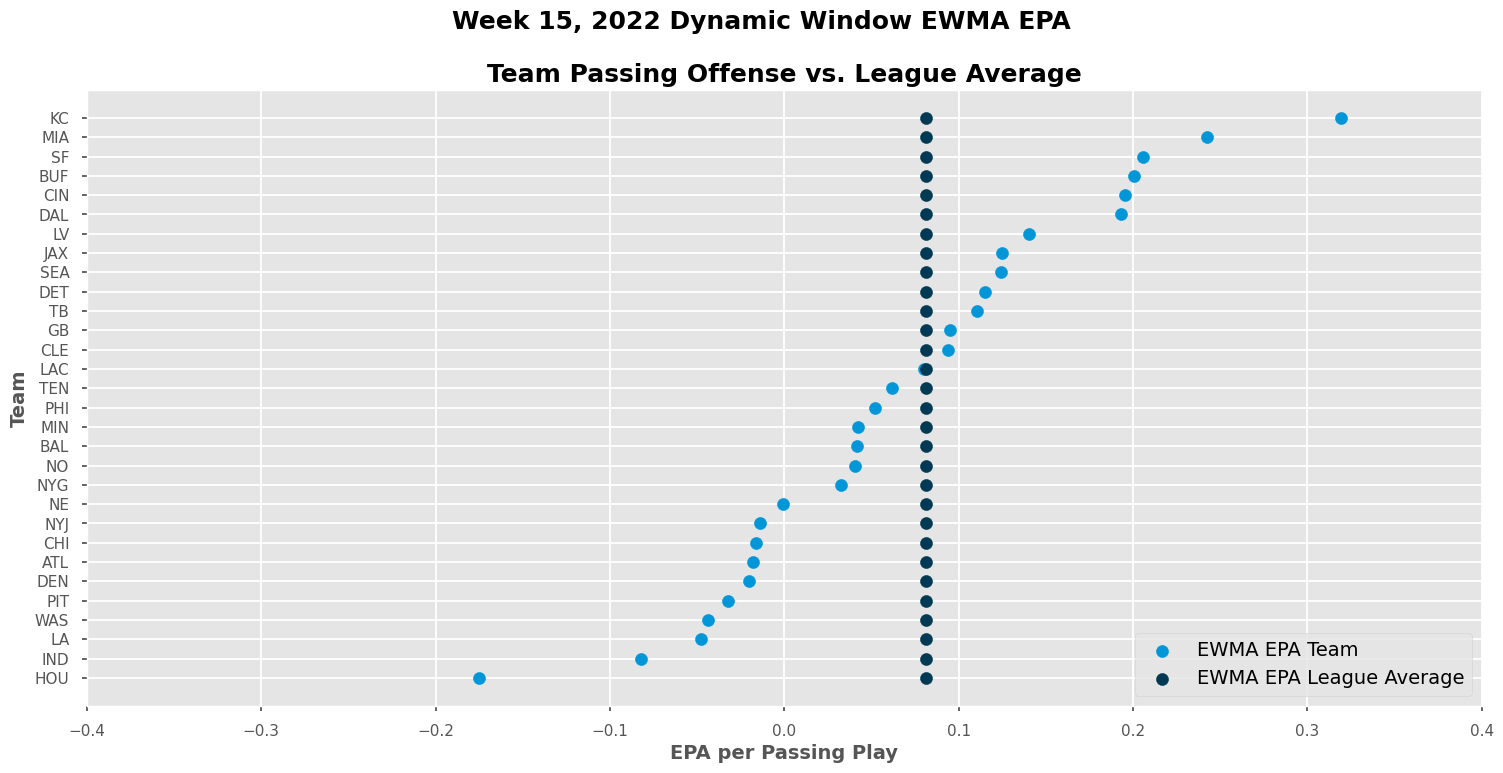

In [12]:
# Create an example DataFrame to visualize week 14, 2022 data
df_vis = epa.loc[(epa['season'] == 2022) & (epa['week'] == 13), :]
df_vis = df_vis[['team', 'ewma_dynamic_window_rushing_offense', 'ewma_dynamic_window_league_rushing_offense',
                    'ewma_dynamic_window_passing_offense', 'ewma_dynamic_window_league_passing_offense']]
df_vis = df_vis.sort_values(by='ewma_dynamic_window_passing_offense', ascending=True)
df_vis = df_vis.reset_index(drop=True)

# Create a Cleveland dot plot comparing team rushing EPA to league average
plt.style.use('seaborn-talk')
plt.figure(figsize=(18, 8));
plt.scatter(df_vis['ewma_dynamic_window_passing_offense'], df_vis['team'], color='#0096d7', s=75, label='EWMA EPA Team', zorder=3);
plt.scatter(df_vis['ewma_dynamic_window_league_passing_offense'], df_vis['team'], color='#003953', s=75, label='EWMA EPA League Average', zorder=3);
plt.legend(loc='lower right', fontsize=14);
plt.suptitle('Week 15, 2022 Dynamic Window EWMA EPA', fontsize=18, fontweight='bold')
plt.title('Team Passing Offense vs. League Average', fontsize=18, fontweight='bold');
plt.xlabel('EPA per Passing Play', fontsize=14, fontweight='bold');
plt.ylabel('Team', fontsize=14, fontweight='bold');
plt.xlim(-.4, .4);
plt.xticks(fontsize=11);
plt.yticks(fontsize=11);

## Further Preprocessing

In [13]:
# Create league adjusted EPA columns by subtracting the league average from the team specific EPA
epa['ewma_dynamic_window_rushing_offense_adjusted'] = epa['ewma_dynamic_window_rushing_offense'] - epa['ewma_dynamic_window_league_rushing_offense']
epa['ewma_dynamic_window_passing_offense_adjusted'] = epa['ewma_dynamic_window_passing_offense'] - epa['ewma_dynamic_window_league_passing_offense']
epa['ewma_dynamic_window_rushing_defense_adjusted'] = epa['ewma_dynamic_window_rushing_defense'] - epa['ewma_dynamic_window_league_rushing_defense']
epa['ewma_dynamic_window_passing_defense_adjusted'] = epa['ewma_dynamic_window_passing_defense'] - epa['ewma_dynamic_window_league_passing_defense']

# Leave only the adjusted columns
epa = epa[['team', 'season', 'week', 'ewma_dynamic_window_rushing_offense_adjusted', 'ewma_dynamic_window_passing_offense_adjusted', 'ewma_dynamic_window_rushing_defense_adjusted', 'ewma_dynamic_window_passing_defense_adjusted']]
epa

,team,season,week,ewma_dynamic_window_rushing_offense_adjusted,ewma_dynamic_window_passing_offense_adjusted,ewma_dynamic_window_rushing_defense_adjusted,ewma_dynamic_window_passing_defense_adjusted
0,ARI,2001,2,-0.051674,-0.211559,0.208689,0.035244
1,ARI,2001,3,-0.146946,-0.151711,0.151274,0.179769
2,ARI,2001,4,-0.096061,-0.154512,0.147711,0.209209
3,ARI,2001,5,-0.123684,0.043325,0.098750,0.288791
4,ARI,2001,6,-0.111464,-0.089584,0.131001,0.034948
...,...,...,...,...,...,...,...
11625,WAS,2022,9,-0.049644,-0.097919,-0.125693,-0.026478
11626,WAS,2022,10,-0.006927,-0.155431,-0.132721,0.019379
11627,WAS,2022,11,0.041345,-0.155040,-0.025044,-0.038466
11628,WAS,2022,12,0.067097,-0.146503,-0.035487,-0.136065


In [14]:
# Create schedule DataFrame and merge in the EPA data
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
    .drop_duplicates().reset_index(drop=True)\
    .assign(home_team_win=lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
    .merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,away_team,home_score,away_score,home_team_win,ewma_dynamic_window_rushing_offense_adjusted_home,ewma_dynamic_window_passing_offense_adjusted_home,ewma_dynamic_window_rushing_defense_adjusted_home,ewma_dynamic_window_passing_defense_adjusted_home,ewma_dynamic_window_rushing_offense_adjusted_away,ewma_dynamic_window_passing_offense_adjusted_away,ewma_dynamic_window_rushing_defense_adjusted_away,ewma_dynamic_window_passing_defense_adjusted_away
0,2001,1,SF,ATL,16,13,1,0.068375,0.373895,0.188975,-0.025906,0.035856,-0.020588,0.046618,0.044612
1,2001,1,MIN,CAR,13,24,0,0.201205,0.272722,0.027694,0.295122,-0.004974,0.106826,0.040380,0.105131
2,2001,1,BAL,CHI,17,6,1,0.056626,0.100741,-0.182264,-0.385600,0.050080,0.120917,0.006948,-0.066058
3,2001,1,GB,DET,28,6,1,0.185993,0.254556,0.034325,-0.053319,0.130579,0.017387,0.004795,-0.123836
4,2001,1,NYJ,IND,24,45,0,-0.038128,0.117377,-0.013457,-0.257729,0.125197,0.414233,0.141943,-0.084094


## Machine Learning (Sci-kit Learn)

In [15]:
# Define the target variable as home_team_win and the adjust EPA columns as features
target = 'home_team_win'
features = ['ewma_dynamic_window_rushing_offense_adjusted_home', 'ewma_dynamic_window_passing_offense_adjusted_home', 'ewma_dynamic_window_rushing_defense_adjusted_home', 'ewma_dynamic_window_passing_defense_adjusted_home', 'ewma_dynamic_window_rushing_offense_adjusted_away', 'ewma_dynamic_window_passing_offense_adjusted_away', 'ewma_dynamic_window_rushing_defense_adjusted_away', 'ewma_dynamic_window_passing_defense_adjusted_away']

In [16]:
# Create features and target variables, drop any rows with missing values, and fit a logistic regression model
df = df.dropna()

X = df.loc[df['season'] != 2022, features].values
y = df.loc[df['season'] != 2022, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [17]:
# Print accuracy and log loss scores
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))


Model Accuracy: 0.6302985898338631


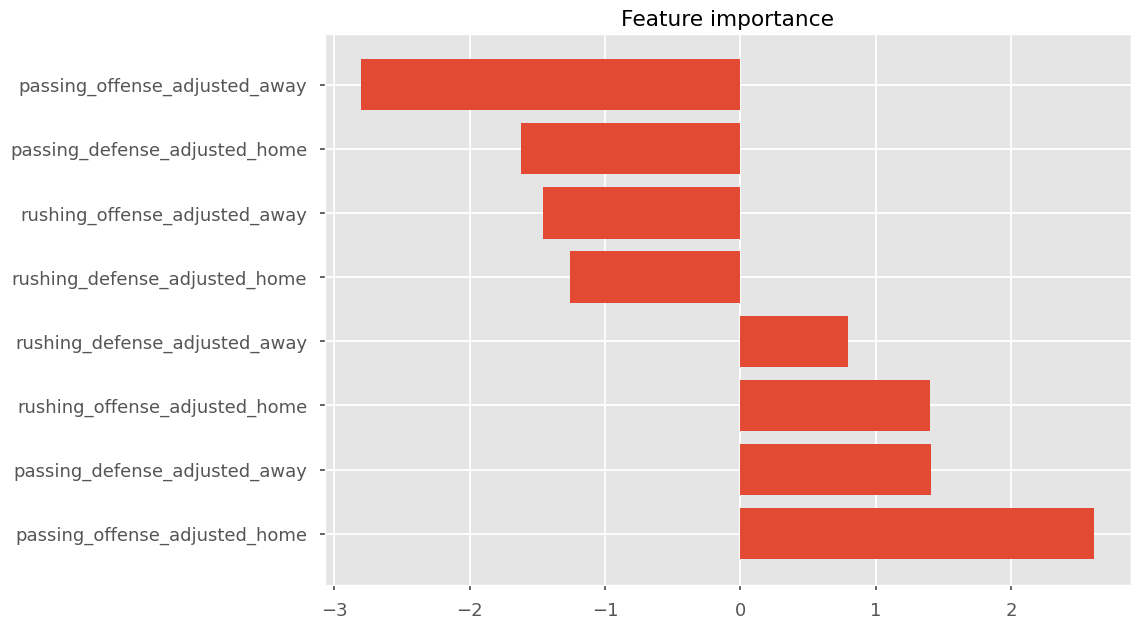

In [18]:
# Visualize feature importance
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:])
                 for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted)
plt.show()


In [19]:
# Create a DataFrame of the 2022 season and make predictions
df_2022 = df.loc[(df['season'] == 2022)].assign(
    predicted_winner=lambda x: clf.predict(x[features]),
    home_team_win_probability=lambda x: clf.predict_proba(x[features])[:, 1]
)[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2022['actual_winner'] = df_2022.apply(
    lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2022['predicted_winner'] = df_2022.apply(
    lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2022['win_probability'] = df_2022.apply(
    lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2022['correct_prediction'] = (
    df_2022['predicted_winner'] == df_2022['actual_winner']).astype(int)

df_2022 = df_2022.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2022.sort_values(by='win_probability',
                    ascending=False).reset_index(drop=True).head(10)


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,TEN,NYG,1,TEN,NYG,0.881265,0
1,MIA,HOU,12,MIA,MIA,0.826099,1
2,BUF,PIT,5,BUF,BUF,0.808283,1
3,DAL,IND,13,DAL,DAL,0.801115,1
4,GB,NYG,5,GB,NYG,0.794033,0
5,PHI,WAS,10,PHI,WAS,0.781265,0
6,KC,LA,12,KC,KC,0.774491,1
7,BUF,GB,8,BUF,BUF,0.768152,1
8,LA,CAR,6,LA,LA,0.757361,1
9,NE,CHI,7,NE,CHI,0.753633,0


In [20]:
# Find the best week of predictions
correct = df_2022.loc[df_2022['correct_prediction'] == 1].groupby('week')[
    'correct_prediction'].sum()

num_games = df_2022.groupby('week')['correct_prediction'].size()

results = correct / num_games

results

week
1     0.687500
2     0.687500
3     0.562500
4     0.625000
5     0.687500
6     0.357143
7     0.500000
8     0.600000
9     0.692308
10    0.357143
11    0.714286
12    0.625000
13    0.800000
14         NaN
Name: correct_prediction, dtype: float64

## Machine Learning (PyCaret)

In [21]:
# Drop the score columns
df = df.drop(columns=['home_score', 'away_score'])

In [22]:
# Initialize PyCaret
from pycaret.classification import *
exp_clf101 = setup(data=df, target='home_team_win', session_id=456)

,Description,Value
0,session_id,456
1,Target,home_team_win
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5814, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [23]:
# Compare the various classification models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6311,0.0000,0.7349,0.6492,0.6891,0.2397,0.2430,0.0240
lda,Linear Discriminant Analysis,0.6304,0.6689,0.7323,0.6491,0.6879,0.2385,0.2417,0.0320
gbc,Gradient Boosting Classifier,0.6242,0.6530,0.7300,0.6435,0.6838,0.2251,0.2283,0.3420
lr,Logistic Regression,0.6240,0.6630,0.7292,0.6435,0.6835,0.2248,0.2277,0.8640
rf,Random Forest Classifier,0.6225,0.6576,0.7265,0.6431,0.6820,0.2218,0.2244,0.2070
ada,Ada Boost Classifier,0.6215,0.6544,0.7054,0.6474,0.6748,0.2241,0.2257,0.1080
lightgbm,Light Gradient Boosting Machine,0.6132,0.6457,0.6921,0.6423,0.6660,0.2080,0.2090,0.0610
et,Extra Trees Classifier,0.6048,0.6351,0.7075,0.6295,0.6661,0.1861,0.1881,0.2090
nb,Naive Bayes,0.5824,0.6261,0.5602,0.6439,0.5987,0.1679,0.1699,0.0200
qda,Quadratic Discriminant Analysis,0.5793,0.6111,0.5906,0.6320,0.6090,0.1542,0.1554,0.0280


In [24]:
# Create a model using the best performing model
gbc = create_model('gbc')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6020,0.6153,0.7434,0.6176,0.6747,0.1732,0.1781
1,0.6413,0.6507,0.7611,0.6515,0.7020,0.2582,0.2631
2,0.6585,0.7176,0.7885,0.6630,0.7203,0.2902,0.2974
3,0.6143,0.6359,0.6960,0.6423,0.6681,0.2094,0.2104
4,0.6462,0.6920,0.7577,0.6590,0.7049,0.2685,0.2726
5,0.6118,0.6380,0.7357,0.6302,0.6789,0.1955,0.1993
6,0.6339,0.6747,0.7137,0.6585,0.6850,0.2497,0.2509
7,0.6216,0.6304,0.7137,0.6454,0.6778,0.2223,0.2239
8,0.6020,0.6468,0.6828,0.6327,0.6568,0.1847,0.1855


In [25]:
# Tune the model
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5774,0.6369,0.9071,0.5758,0.7045,0.0784,0.1093
1,0.5971,0.6561,0.9558,0.5838,0.7248,0.1139,0.1814
2,0.6118,0.7057,0.9736,0.5925,0.7367,0.1410,0.2318
3,0.6143,0.6464,0.9163,0.6012,0.7260,0.1606,0.2082
4,0.6241,0.6775,0.9383,0.6051,0.7358,0.1790,0.2413
5,0.6020,0.6554,0.9427,0.5895,0.7254,0.1247,0.1839
6,0.6192,0.6738,0.9163,0.6047,0.7285,0.1723,0.2207
7,0.5897,0.6461,0.9163,0.5843,0.7136,0.1016,0.1411
8,0.5971,0.6660,0.9515,0.5854,0.7248,0.1106,0.1733


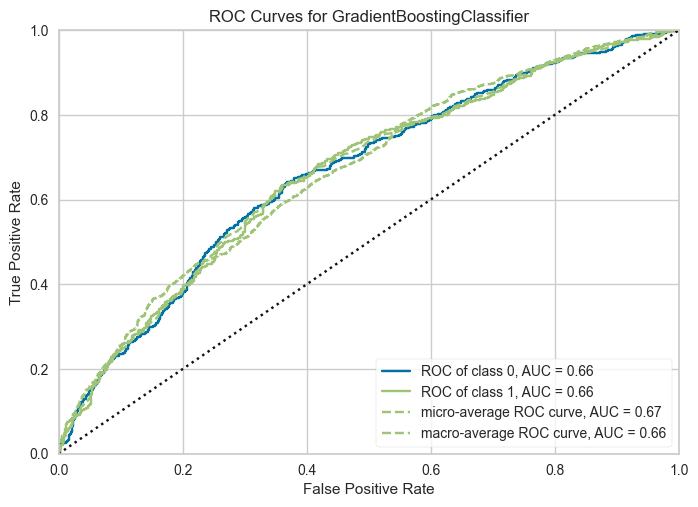

In [26]:
# Plot the ROC curve
plot_model(tuned_gbc, plot='auc')

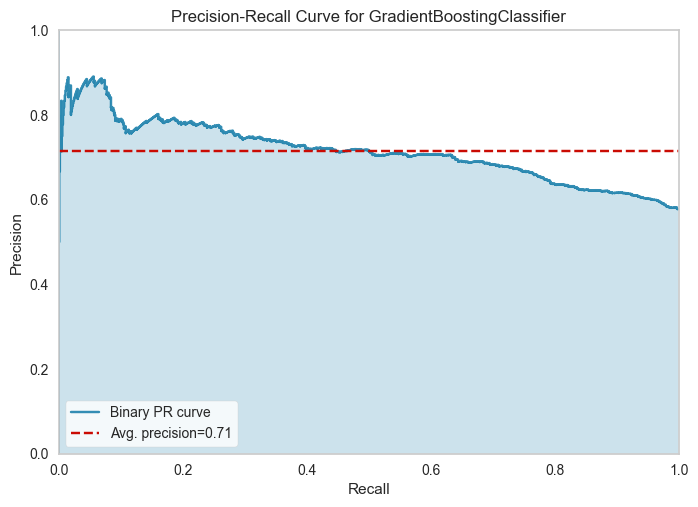

In [27]:
# Plot the precision recall curve
plot_model(tuned_gbc, plot='pr')

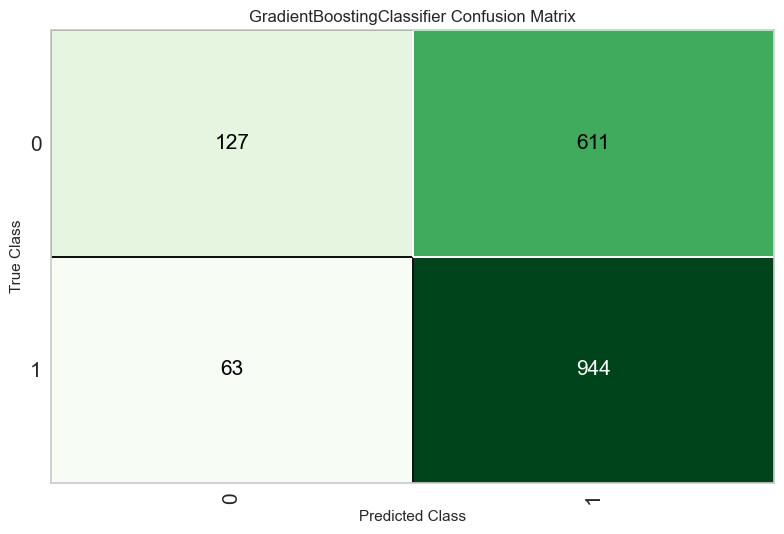

In [28]:
# Plot the confusion matrix
plot_model(tuned_gbc, plot='confusion_matrix')